<a href="https://colab.research.google.com/github/plthiyagu/Personnel/blob/master/Multiple_Times_modeling_using_Apache_Spark_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

openjdk version "1.8.0_265"
OpenJDK Runtime Environment (build 1.8.0_265-8u265-b01-0ubuntu2~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.265-b01, mixed mode)


In [2]:
!pip install pyspark

In [3]:
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.0.1
      /_/
                        
Using Scala version 2.12.10, OpenJDK 64-Bit Server VM, 1.8.0_265
Branch HEAD
Compiled by user ubuntu on 2020-08-28T07:36:48Z
Revision 2b147c4cd50da32fe2b4167f97c8142102a0510d
Url https://gitbox.apache.org/repos/asf/spark.git
Type --help for more information.


In [6]:
!pip install -q findspark

In [4]:
!pip install pyarrow==0.15.1

In [8]:
!pip install fbprophet

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from fbprophet import Prophet

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [7]:
from pyspark.sql import SparkSession
import pyspark
spark = SparkSession.builder.master('local').getOrCreate()

In [8]:
df = pd.read_csv("https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/weekly_sales_data.csv")
df.head()

,date,store_id,sales
0,1/6/2019,25,736657.2267
1,1/6/2019,26,233711.0000
2,1/6/2019,28,692156.3794
3,1/6/2019,29,213706.8000
4,1/6/2019,30,266455.0000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      500 non-null    object 
 1   store_id  500 non-null    int64  
 2   sales     500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ KB


In [10]:
df['date']= pd.to_datetime(df['date'],infer_datetime_format=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      500 non-null    datetime64[ns]
 1   store_id  500 non-null    int64         
 2   sales     500 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.8 KB


In [12]:
print("\nFeatures         :\n",df.columns.to_list())
print("\Missing Values    :\n",df.isnull().any())
print("\nUnique Values    :\n", df.nunique())


Features         :
 ['date', 'store_id', 'sales']
\Missing Values    :
 date        False
store_id    False
sales       False
dtype: bool

Unique Values    :
 date         50
store_id     10
sales       500
dtype: int64


In [13]:
df.describe()

,store_id,sales
count,500.0000,5.000000e+02
mean,32.7000,4.470800e+05
std,6.1714,2.970660e+05
min,25.0000,1.278800e+04
25%,28.0000,2.526557e+05
50%,30.5000,3.150259e+05
75%,38.0000,6.845418e+05
max,44.0000,1.631585e+06


In [15]:
df_base= df.copy()

In [16]:
df['store_id'].value_counts()

44    50
41    50
38    50
35    50
31    50
30    50
29    50
28    50
26    50
25    50
Name: store_id, dtype: int64

In [17]:
item_df= df.set_index('date')

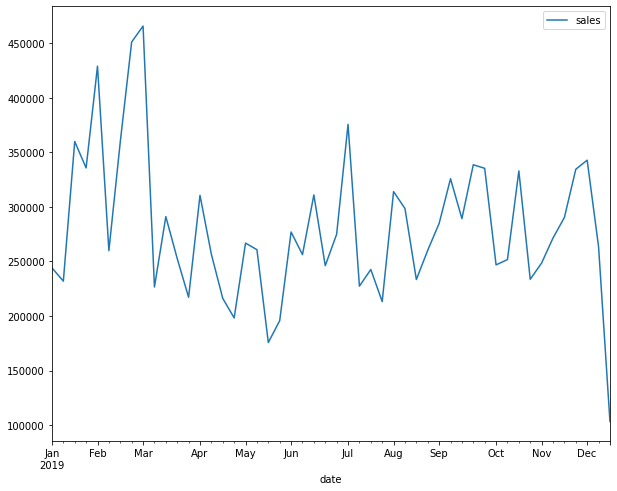

In [18]:
item_df.query("store_id==41")[['sales']].plot();

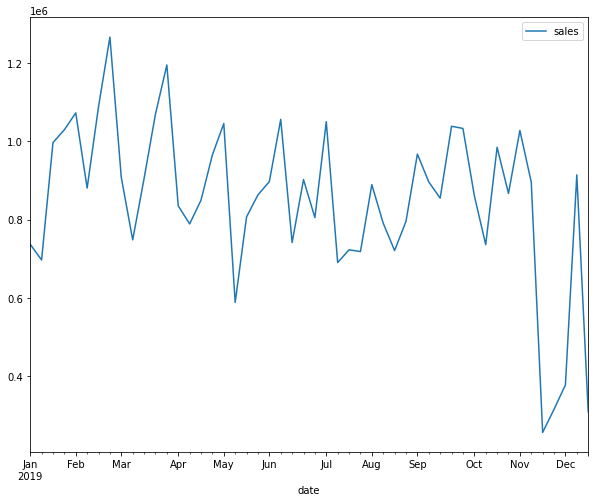

In [19]:
item_df.query("store_id==25")[['sales']].plot();

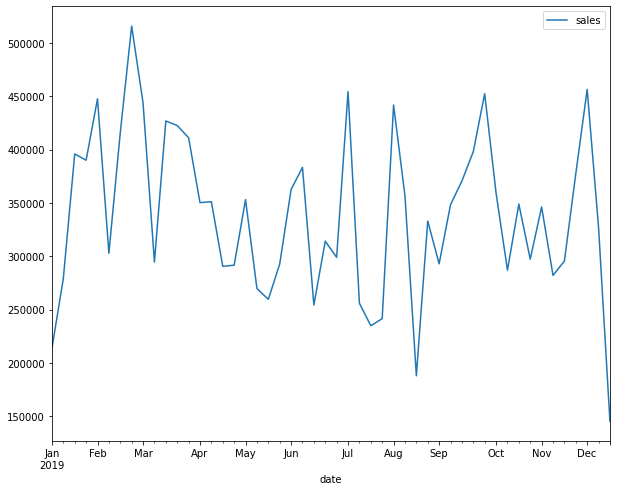

In [20]:
item_df.query("store_id==29")[['sales']].plot();

In [106]:
sdf=spark.createDataFrame(df)

In [107]:
sdf.show(5)

+-------------------+--------+-----------+
|               date|store_id|      sales|
+-------------------+--------+-----------+
|2019-01-06 00:00:00|      25|736657.2267|
|2019-01-06 00:00:00|      26|   233711.0|
|2019-01-06 00:00:00|      28|692156.3794|
|2019-01-06 00:00:00|      29|   213706.8|
|2019-01-06 00:00:00|      30|   266455.0|
+-------------------+--------+-----------+
only showing top 5 rows



In [74]:
sdf.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- store_id: long (nullable = true)
 |-- sales: double (nullable = true)



In [108]:
sdf.count()

500

In [109]:
sdf.createOrReplaceTempView("sales")

In [110]:
spark.sql("select store_id,count(*) from sales group by store_id order by store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      25|      50|
|      26|      50|
|      28|      50|
|      29|      50|
|      30|      50|
|      31|      50|
|      35|      50|
|      38|      50|
|      41|      50|
|      44|      50|
+--------+--------+



In [111]:
sql = 'SELECT store_id, date as ds, sum(sales) as y FROM  sales GROUP BY store_id, ds ORDER BY store_id, ds'

In [112]:
spark.sql(sql).show()

+--------+-------------------+------------------+
|store_id|                 ds|                 y|
+--------+-------------------+------------------+
|      25|2019-01-06 00:00:00|       736657.2267|
|      25|2019-01-13 00:00:00|       696457.1717|
|      25|2019-01-20 00:00:00|        996876.875|
|      25|2019-01-27 00:00:00|        1029737.05|
|      25|2019-02-03 00:00:00|       1072873.705|
|      25|2019-02-10 00:00:00|       880462.4681|
|      25|2019-02-17 00:00:00|        1088756.78|
|      25|2019-02-24 00:00:00|       1266928.313|
|      25|2019-03-03 00:00:00|       907510.1217|
|      25|2019-03-10 00:00:00|       747920.9824|
|      25|2019-03-17 00:00:00|       904750.3158|
|      25|2019-03-24 00:00:00|1069857.5890000002|
|      25|2019-03-31 00:00:00|       1195574.314|
|      25|2019-04-07 00:00:00|       834911.3333|
|      25|2019-04-14 00:00:00|       788777.4167|
|      25|2019-04-21 00:00:00|       849603.4333|
|      25|2019-04-28 00:00:00|        965521.165|


In [113]:
sdf.explain()

== Physical Plan ==
*(1) Scan ExistingRDD[date#1995,store_id#1996L,sales#1997]




In [114]:
sdf.rdd.getNumPartitions()

1

In [115]:
store_part=(spark.sql(sql).repartition(spark.sparkContext.defaultParallelism,['store_id'])).cache()

In [116]:
store_part

DataFrame[store_id: bigint, ds: timestamp, y: double]

In [117]:
store_part.explain()

== Physical Plan ==
InMemoryTableScan [store_id#1996L, ds#2081, y#2082]
   +- InMemoryRelation [store_id#1996L, ds#2081, y#2082], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(store_id#1996L, 1), false, [id=#976]
            +- *(3) Sort [store_id#1996L ASC NULLS FIRST, ds#2081 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(store_id#1996L ASC NULLS FIRST, ds#2081 ASC NULLS FIRST, 200), true, [id=#972]
                  +- *(2) HashAggregate(keys=[store_id#1996L, date#1995], functions=[sum(sales#1997)])
                     +- Exchange hashpartitioning(store_id#1996L, date#1995, 200), true, [id=#968]
                        +- *(1) HashAggregate(keys=[store_id#1996L, date#1995], functions=[partial_sum(sales#1997)])
                           +- *(1) Scan ExistingRDD[date#1995,store_id#1996L,sales#1997]




In [118]:
from pyspark.sql.types import *

result_schema =StructType([
                           StructField('ds',TimestampType()),
                           StructField('store_id',IntegerType()),
                           StructField('y',DoubleType()),
                           StructField('yhat',DoubleType()),
                           StructField('yhat_upper',DoubleType()),
                           StructField('yhat_lower',DoubleType())
])

In [119]:
from pyspark.sql.functions import pandas_udf,PandasUDFType

@pandas_udf(result_schema,PandasUDFType.GROUPED_MAP)

def forecast_sales(store_pd):
  model =Prophet(interval_width=0.95,seasonality_mode='multiplicative',weekly_seasonality=True,yearly_seasonality=True)
  model.fit(store_pd)

  future_pd = model.make_future_dataframe(
      periods=5,
      freq='w'
  )
  forecast_pd = model.predict(future_pd)

  f_pd =forecast_pd[['ds','yhat','yhat_upper','yhat_lower']].set_index('ds')
  st_pd = store_pd[['ds','store_id','y']].set_index('ds')

  result_pd =f_pd.join(st_pd,how='left')
  result_pd.reset_index(level=0, inplace=True)
  result_pd['store_id']= store_pd['store_id'].iloc[0]

  return result_pd [['ds','store_id','y','yhat','yhat_upper','yhat_lower']]



In [120]:
from pyspark.sql.functions import current_date

results=(
    store_part
    .groupBy('store_id')
    .apply(forecast_sales)
    .withColumn('training_date',current_date())

)

/usr/local/lib/python3.6/dist-packages/pyspark/sql/pandas/group_ops.py:76: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [121]:
results.cache()

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [122]:
results.show()

+-------------------+--------+------------------+------------------+------------------+------------------+-------------+
|                 ds|store_id|                 y|              yhat|        yhat_upper|        yhat_lower|training_date|
+-------------------+--------+------------------+------------------+------------------+------------------+-------------+
|2019-01-06 00:00:00|      25|       736657.2267| 712575.0694095818| 944247.8848601249| 490541.2203680857|   2020-10-08|
|2019-01-13 00:00:00|      25|       696457.1717| 743751.7568979745| 963987.3859748896|512388.47554873675|   2020-10-08|
|2019-01-20 00:00:00|      25|        996876.875| 972909.8778074606|1201136.7201516894| 750703.9986539291|   2020-10-08|
|2019-01-27 00:00:00|      25|        1029737.05|1034447.5557655566|1281710.3248981189| 796029.1203476639|   2020-10-08|
|2019-02-03 00:00:00|      25|       1072873.705| 986365.7266813249|1230485.5075665866| 755821.1736624571|   2020-10-08|
|2019-02-10 00:00:00|      25|  

In [123]:
results.explain()

== Physical Plan ==
InMemoryTableScan [ds#2157, store_id#2158, y#2159, yhat#2160, yhat_upper#2161, yhat_lower#2162, training_date#2169]
   +- InMemoryRelation [ds#2157, store_id#2158, y#2159, yhat#2160, yhat_upper#2161, yhat_lower#2162, training_date#2169], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(2) Project [ds#2157, store_id#2158, y#2159, yhat#2160, yhat_upper#2161, yhat_lower#2162, 18543 AS training_date#2169]
            +- FlatMapGroupsInPandas [store_id#1996L], forecast_sales(store_id#1996L, ds#2081, y#2082), [ds#2157, store_id#2158, y#2159, yhat#2160, yhat_upper#2161, yhat_lower#2162]
               +- *(1) Sort [store_id#1996L ASC NULLS FIRST], false, 0
                  +- InMemoryTableScan [store_id#1996L, store_id#1996L, ds#2081, y#2082]
                        +- InMemoryRelation [store_id#1996L, ds#2081, y#2082], StorageLevel(disk, memory, deserialized, 1 replicas)
                              +- Exchange hashpartitioning(store_id#1996L, 1), fals

In [124]:
results.coalesce(1)

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [125]:
results.createOrReplaceTempView('forcasted')

In [127]:
spark.sql('select store_id,count(*) from forcasted group by store_id').show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      31|      55|
|      28|      55|
|      26|      55|
|      44|      55|
|      41|      55|
|      35|      55|
|      38|      55|
|      25|      55|
|      29|      55|
|      30|      55|
+--------+--------+



In [128]:
final_df= results.toPandas()

In [129]:
final_df

,ds,store_id,y,yhat,yhat_upper,yhat_lower,training_date
0,2019-01-06,25,7.366572e+05,7.125751e+05,9.442479e+05,490541.220368,2020-10-08
1,2019-01-13,25,6.964572e+05,7.437518e+05,9.639874e+05,512388.475549,2020-10-08
2,2019-01-20,25,9.968769e+05,9.729099e+05,1.201137e+06,750703.998654,2020-10-08
3,2019-01-27,25,1.029737e+06,1.034448e+06,1.281710e+06,796029.120348,2020-10-08
4,2019-02-03,25,1.072874e+06,9.863657e+05,1.230486e+06,755821.173662,2020-10-08
...,...,...,...,...,...,...,...
545,2019-12-22,44,NaN,6.265474e+04,1.260991e+05,-2244.195694,2020-10-08
546,2019-12-29,44,NaN,2.657442e+04,9.121606e+04,-37149.123517,2020-10-08
547,2020-01-05,44,NaN,8.801264e+03,7.096872e+04,-54174.654845,2020-10-08
548,2020-01-12,44,NaN,4.665900e+03,7.064309e+04,-60507.848185,2020-10-08


In [131]:
final_df.set_index('ds')

,store_id,y,yhat,yhat_upper,yhat_lower,training_date
ds,,,,,,
2019-01-06,25,7.366572e+05,7.125751e+05,9.442479e+05,490541.220368,2020-10-08
2019-01-13,25,6.964572e+05,7.437518e+05,9.639874e+05,512388.475549,2020-10-08
2019-01-20,25,9.968769e+05,9.729099e+05,1.201137e+06,750703.998654,2020-10-08
2019-01-27,25,1.029737e+06,1.034448e+06,1.281710e+06,796029.120348,2020-10-08
2019-02-03,25,1.072874e+06,9.863657e+05,1.230486e+06,755821.173662,2020-10-08
...,...,...,...,...,...,...
2019-12-22,44,NaN,6.265474e+04,1.260991e+05,-2244.195694,2020-10-08
2019-12-29,44,NaN,2.657442e+04,9.121606e+04,-37149.123517,2020-10-08
2020-01-05,44,NaN,8.801264e+03,7.096872e+04,-54174.654845,2020-10-08


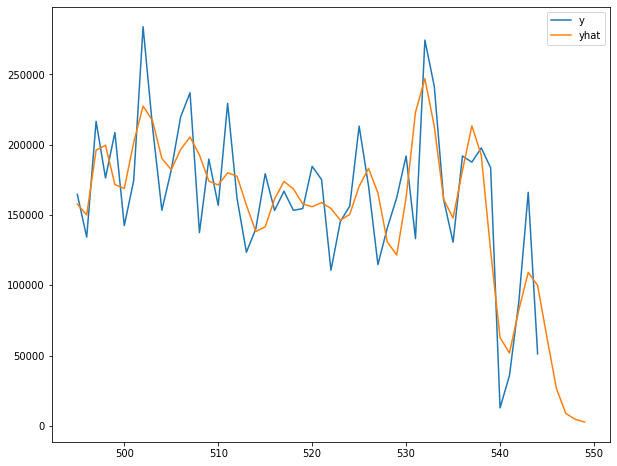

In [132]:
final_df.query('store_id == 44')[['y','yhat']].plot()